In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation
## Due Date: Thursday, November 30th, 11:59 PM PDT
You must submit this assignment to Gradescope by the on-time deadline, Thursday, November 30th, 11:59 PM. 
Please read the syllabus for the grace period policy. 
No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). 
**We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** 
This way, you will have ample time to reach out to staff for submission support.

### Collaboration Policy

Data science is a collaborative activity. 
While you may talk with others about this project, we ask that you **write your solutions individually**. 
If you discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
In this project, you will build and improve on the concepts and functions you implemented in Project B1 to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit classification models,
- Validating the performance of your model and minimizing overfitting, and
- Generating and analyzing ROC curves.

## Content Warning
This is a **real-world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails and wanted to warn you at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your GSI or the instructors, or reach out via the Fall 2023 [extenuating circumstances form](https://docs.google.com/forms/d/e/1FAIpQLSffIhNMwsxP9Pd5l_9dzx_V4VffsNIOOjOexLT9VgUtmzw4AA/viewform).**

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response questions, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1 | Yes | 6
2a | Yes | 4
2b | Yes | 2
3 | Yes | 3
4a | No | 5
4b | No | 10
Total | 4 | 30

In [3]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Setup and Recap

Here, we will provide a summary of Project B1 to remind you of how we cleaned the data, explored it, and implemented methods helpful in building your own model.

## Loading and Cleaning Data

Remember that in email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
#original_training_data['email'] = original_training_data['email'].str.lower()
#test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [6]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, split the training data into separate training and validation datasets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

As in Project B1, we set the seed (`random_state`) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [7]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [8]:
from projB2_utils import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In Project B1, we proceeded to visualize the frequency of different words for both spam and ham emails and used `words_in_texts(words, train['email'])` to directly to train a classifier. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [9]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7532277385864502


## Evaluating Classifiers

In our models, we are evaluating the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to lead us to consider more ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, i.e., preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. To get full credit on the accuracy part of this assignment, you must get at least **85%** accuracy on both the train and test set (see Q4 for the partial credit breakdown). To see your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame` and upload your predictions to Gradescope.

**Gradescope limits to 3 submissions per day to meet the threshold**. You will be able to see your accuracy on the entire test set when submitting to Gradescope. In the case that you are approved for an extension, you are granted 3 more submissions for each day the deadline has been extended.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code your own cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 3 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well, the documentation is your friend!     
       
You may use whatever method you prefer in order to create features, but **you may only use the packages we've imported for you in the cell below or earlier in this notebook**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 1, 2, and 3 should help guide you.

**Note:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

In [11]:
# import libraries
# you may use any of these to create your features
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import GridSearchCV
import re
from collections import Counter

In [12]:
# Separate spam and ham emails
spam_emails = original_training_data[original_training_data["spam"] == 1]
ham_emails = original_training_data[original_training_data["spam"] == 0]

spam_tokenized_words = ' '.join(spam_emails['email']).split()
spam_word_counts = Counter(spam_tokenized_words)
top_spam_words = spam_word_counts.most_common(20)

ham_tokenized_words = ' '.join(ham_emails['email']).split()
ham_word_counts = Counter(ham_tokenized_words)
top_ham_words = ham_word_counts.most_common(20)

# Create DataFrames with top words for spam and ham
top_spam_df = pd.DataFrame({
    'Spam Word': [word[0] for word in top_spam_words],
    'Spam Count': [word[1] for word in top_spam_words]
})

top_ham_df = pd.DataFrame({
    'Ham Word': [word[0] for word in top_ham_words],
    'Ham Count': [word[1] for word in top_ham_words]
})

merged_df = pd.merge(top_spam_df, top_ham_df, left_on='Spam Word', right_on='Ham Word', how='inner')
merged_df["Spam Prop"] = merged_df["Spam Count"]/ len(spam_emails)
merged_df["Ham Prop"] = merged_df["Ham Count"]/ len(ham_emails)
merged_df["Diff"] = merged_df["Spam Prop"]- merged_df["Ham Prop"]

merged_df2 = merged_df.sort_values("Diff", ascending = False)
merged_df2

,Spam Word,Spam Count,Ham Word,Ham Count,Spam Prop,Ham Prop,Diff
4,you,10736,you,9613,5.016822,1.548486,3.468337
1,to,18887,to,41322,8.825701,6.656250,2.169451
2,and,14987,and,31747,7.003271,5.113885,1.889386
9,<td,6691,<td,9806,3.126636,1.579575,1.547061
3,of,13644,of,31970,6.375701,5.149807,1.225894
10,this,5056,this,7913,2.362617,1.274646,1.087971
6,for,7884,for,16228,3.684112,2.614046,1.070066
14,are,3901,are,7497,1.822897,1.207635,0.615262
7,in,7706,in,20317,3.600935,3.272713,0.328222
13,with,4024,with,9782,1.880374,1.575709,0.304665


In [13]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!

# Number of characters in the subject/body

# Number of words in the subject/body
def num_words(email):
    # string_wo_quotes = email.replace('"', '').replace("'", '')
    # print(string_wo_quotes)
    return len(email.split())

# Use of punctuation (e.g., how many '!'s were there?)
def count_punc(email):
    #print(email)
    punctuations = re.findall(r'[^\w\s]', email)
    #print(punctuations)
    return len(punctuations)

def prop_punc(email):
    if pd.isna(email):
        return 0
        
    if len(email) == 0:
        return 0
        
    #print(email)
    punctuations = re.findall(r'[^\w\s]', email)
    #print(punctuations)
    return len(punctuations)/len(email)

def prop_digit(email):
    if pd.isna(email):
        return 0  
    if len(email) == 0:
        return 0
        
    digits = re.findall(r'\d', email)
   
    return len(digits) / len(email)

# Number/percentage of capital letters in subject line
def prop_caps(subject):
    if pd.isna(subject):
        return 0
    if len(subject) == 0:
        return 0
    return sum(1 for c in subject if c.isupper())/len(subject)

def reply_or_forward(subject):
    if pd.isna(subject):
        return 0
        
    if len(subject) == 0:
        return 0

    subject_lower = subject.lower()
    return 1 if "fwd:" in subject_lower or "re:" in subject_lower else 0


#2. Finding better (and/or more) words to use as features.
more_words = ['drug', 'bank', 'prescription', 'memo', 'private', 'body', 'business', 'money', 
              'click', '100%', 'free', 'really', 'show', 'the', 'you', 'subscribe', 
              'luxury', 'call', 'deal', 'of']

#3. Better data processing, extract text from HTML
def extract_text_from_html(email):
    if "<html>" not in email.lower():
        return email
    
    inside_tag = False
    result = []

    for char in email:
        if char == '<':
            inside_tag = True
        elif char == '>':
            inside_tag = False
        elif not inside_tag:
            result.append(char)

    extracted_text = ''.join(result)
    return extracted_text

In [14]:
def new_df(df):
    #3
    df["email"] = df["email"].apply(extract_text_from_html)

    #2
    w_i_t_df = pd.DataFrame(words_in_texts(more_words, df["email"]))
    #df = df.join(w_i_t_df)
    w_i_t_df["id"] = df["id"]
    df = df.merge(w_i_t_df, left_on='id', right_on='id')

    #1
    df["prop_punc_s"] = df["subject"].apply(prop_punc)
    df["prop_punc_e"] = df["email"].apply(prop_punc)
    
    df["prop_caps_s"] = df["subject"].apply(prop_caps)
    df["prop_caps_e"] = df["email"].apply(prop_caps)

    df["prop_digit_s"] = df["subject"].apply(prop_digit)
    df["prop_digit_e"] = df["email"].apply(prop_digit)

    df["re_or_fwd"] = df["subject"].apply(reply_or_forward)

    #df["num_words"] = df["email"].apply(num_words)
    df.columns = df.columns.astype(str)

    return df
    

In [15]:
new_train = train.copy()
new_val = val.copy()
new_test = test.copy()

new_train = new_df(new_train)
new_val = new_df(new_val)
new_test = new_df(new_test)

#new_train

In [16]:
new_test.head()

,id,subject,email,0,1,2,3,4,5,6,...,17,18,19,prop_punc_s,prop_punc_e,prop_caps_s,prop_caps_e,prop_digit_s,prop_digit_e,re_or_fwd
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----BEGIN PGP SIGNED MESSAGE-----\n \n ...,0,0,0,1,0,1,0,...,1,0,1,0.054545,0.030932,0.218182,0.062121,0.109091,0.015893,0
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,Low-Cost Term-Life Insurance!\n SAVE up to 70%...,0,0,0,0,0,0,0,...,0,0,1,0.043478,0.098318,0.152174,0.058215,0.000000,0.025873,0
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_NextPart_000_00A0_03E30A1A.B1804B54\n ...,0,0,0,0,0,0,0,...,0,0,0,0.044444,0.020619,0.666667,0.372071,0.000000,0.136832,0
3,3,Subject: Marriage makes both sexes happy\n,"URL: http://www.newsisfree.com/click/-3,848315...",0,0,0,0,0,0,0,...,0,0,0,0.024390,0.072539,0.048780,0.031088,0.000000,0.062176,0
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,On Thursday 29 August 2002 16:39 CET Mike Burg...,0,0,0,0,0,0,0,...,0,0,1,0.113924,0.154180,0.075949,0.028230,0.000000,0.021716,1


In [17]:
X_train = new_train.iloc[:, 4:]
Y_train = new_train['spam']

X_val = new_val.iloc[:, 4:]
Y_val = new_val['spam']

X_test = new_test.iloc[:, 3:]

model = LogisticRegression(fit_intercept=True, penalty='l2')
model.fit(X_train, Y_train)
val_pred = model.predict(X_val)
train_pred = model.predict(X_train)

print(accuracy_score(Y_val, val_pred), accuracy_score(Y_train, train_pred))

0.8181818181818182 0.8839345135099161


In [18]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,prop_punc_s,prop_punc_e,prop_caps_s,prop_caps_e,prop_digit_s,prop_digit_e,re_or_fwd
0,0,0,0,1,0,1,0,0,0,0,...,1,0,1,0.054545,0.030932,0.218182,0.062121,0.109091,0.015893,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.043478,0.098318,0.152174,0.058215,0.000000,0.025873,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.044444,0.020619,0.666667,0.372071,0.000000,0.136832,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0.024390,0.072539,0.048780,0.031088,0.000000,0.062176,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.113924,0.154180,0.075949,0.028230,0.000000,0.021716,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0.073171,0.071900,0.097561,0.052111,0.024390,0.022427,1
996,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.055556,0.102767,0.138889,0.039526,0.000000,0.000000,1
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.074074,0.067742,0.111111,0.035484,0.000000,0.009677,1
998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.085106,0.053952,0.191489,0.033877,0.000000,0.002509,1


<!-- BEGIN QUESTION -->

<br>

---

## Question 1

In the following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the following questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?


1. Initially I followed all the suggestions like finding the percent of capital letter in subject etc. But I only got around 50% accuracy for the validation set. I then decided to apply all these filters for both the subject and email. And it also took a significant amount of time to find the most appeared word in spam and ham emails to decide on the best words to use.

2. I thought that num punc would be very efficient, but I saw some emails that are not spam has very high number of punctuations it turned out that it was written in html thus detected lots of non characters. Did some html extraction and it improved the accuracy. Also, the number of punctuations really does not matter, because the length of emails varies, so I tried proportion of punctuations intead.

4. Some words are surprisingly very frequently used in spam email like "you", "to", "and". Try including number of words in the email. Does not improve the model.

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

In the cell below, show a visualization you used to select features for your model. 

Please include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your feature selection process, but select only one for the response cell below.

**You should not just produce an identical visualization to Question 3 in Project B1.** For this section, we’d like you to go beyond the analysis you performed in Project B1. Choose some plot other than the 1-dimensional distribution of some quantity for spam and ham emails. In particular, do not produce a bar plot of proportions like you created in Question 3 of Project B1. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html)). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

<br>

---

## Question 2a

Generate your visualization in the cell below.


<Axes: xlabel='variable', ylabel='value'>

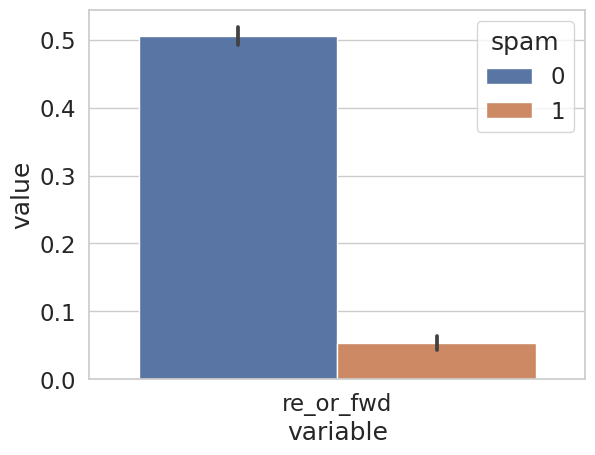

In [19]:
melt_re_or_fwd = new_train[['spam', 're_or_fwd']].melt('spam')
sns.barplot(x = melt_re_or_fwd['variable'], y = melt_re_or_fwd['value'], hue = melt_re_or_fwd['spam'])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 2b

Write your commentary in the cell below.


Using the melt function introduced from B1, I comparethe proportion of spam and ham emails that are either fowarded email or replies. For the first visualization there is a clear difference in height between spam and ham emails, that emails that are either fowarded email or replies are most likely to be ham emails.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 3: ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**: We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 23 to see how to plot an ROC curve.

**Hint**: You'll want to use the `.predict_proba` method for your classifier instead of `.predict` to get probabilities instead of binary predictions.


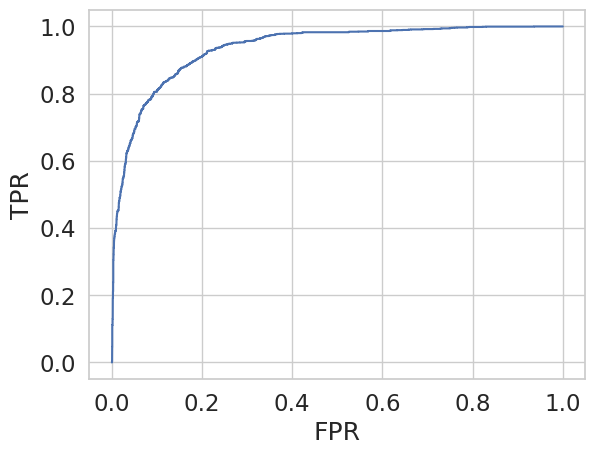

In [20]:
p = model.predict_proba(X_train)[:, 1]
#display(model.classes_)
fprs, tprs, T = roc_curve(Y_train, p)

plt.plot(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR");

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Question 4

### Grading Scheme

Your grade for Question 4 will be based on your model’s accuracy when making predictions on the training set and your model’s accuracy when making predictions on the test set. The tables below provide scoring guidelines. If your accuracy lies in a particular range, you will receive the number of points associated with that range.
**Important**: While your training accuracy can be checked at any time in this notebook, your test accuracy can only be checked by submitting your model’s predictions to Gradescope. **You may only submit to Gradescope 3 times per day to meet the threshold**. In the case that you are approved for an extension, you are granted 3 more submissions for each day the deadline has been extended. Plan ahead to make sure you have enough time to fine-tune your model! The thresholds are as follows:

Points | 5 | 3 | 1.5 | 0
--- | --- | --- | --- | ---
**Training** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%

Points | 10 | 6 | 3 | 0
--- | --- | --- | --- | ---
**Testing** Accuracy | 85% and Above | \[80, 85) | \[70, 80) | Below 70%


<br><br>

---

## Question 4a: Train Predictions
Assign your predictions for the class of each data point in the training set `train` to the variable `train_predictions`.

In [21]:
train_predictions = model.predict(X_train)

# print your training accuracy 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.8839345135099161

In [22]:
grader.check("q4a")

q4a results: All test cases passed!

<br>

---

## Question 4b: Test Set Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project B2 Test Set Predictions" assignment on Gradescope to get credit for this question.**

Assign your predictions for the class of each data point in the test set `test` to a 1-dimensional array called `test_predictions`. **Please make sure you save your predictions to `test_predictions`, as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Gradescope limits you to 3 submissions per day to meet the threshold.** In the case that you are approved for an extension, you are granted 3 more submissions for each day the deadline has been extended.

The provided tests check that your predictions are in the correct format but are worth 0 points in the *Project B2 Coding assignment*. You must additionally submit to the *Project B2 Test Set Predictions* assignment to evaluate your classifier accuracy.

In [23]:
test_predictions = model.predict(X_test)

In [24]:
grader.check("q4b")

q4b results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project B2 Test Predictions" assignment on Gradescope to get credit for this question.** You can only submit to Gradescope a maximum of 3 times per day, so please use your submissions wisely!

In [25]:
# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

Created a CSV file: submission_20240601_013546.csv.


You may now upload this CSV file to Gradescope for scoring.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mila congratulates you for finishing Project B2!

![](mila.jpeg)

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project B2) and the written portion (the PDF with from Project B2) to their respective Gradescope portals and checking that they are the most recent copy or the copy you wish to submit (including plots and all written answers).** The coding proportion should be submitted to Project B2 Coding as a single zip file, and the written portion should be submitted to Project B2 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately. In addition, you must submit your test prediction in Q4b to **Project B2 Test Set Predictions** for the corresponding points. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

After you have run the cell below and generated the zip file, you can open the PDF <a href='projB2.pdf' download>here</a>.

In [26]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q4a results: All test cases passed!

    q4b results: All test cases passed!
